Chambolle-Pock Primal-Dual Splitting Algorithm
==============================
$\newcommand{\umin}[1]{\underset{#1}{\min}\;}$


We have seen in the lab 3 that total variation denoising can be performed using the dual forward-backward algorithm. But the setting is restrictive: this algorithm cannot be applied to general inverse problems. 

This tour explores the primal-dual proximal splitting algorithm proposed in 

A. Chambolle and T. Pock, "A First-order primal-dual algorithm for convex problems with application to imaging,"
_Journal of Mathematical Imaging and Vision_,
vol. 40, no. 1, 2011

and further analyzed and extended in 

L. Condat, "A primal-dual splitting method for convex optimization involving Lipschitzian, proximable and linear composite terms," _J. Optimization Theory and Applications_, vol. 158, no. 2, 2013.

In [4]:
from __future__ import division
%pylab inline
%load_ext autoreload
%autoreload 2


Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


Convex Optimization with a Primal-Dual Scheme
---------------------------------------------

We consider a (primal) optimization problem of the form
$$ \umin{x} f(x) + g(Lx) $$
where $f$ and $g$ are convex functions, whose proximity operators can be computed, and $L$
is a linear operator.

The dual problem is 

$$ \umin{u} f^*(-L^*u) + g^*(u) $$

The (relaxed) Chambolle-Pock algorithm takes initial estimates $x^{(0)}$ and $u^{(0)}$ of the primal and dual solutions, a parameter $\tau>0$, a second parameter $0<\sigma\leq 1/(\tau\|L\|^2)$, a relaxation parameter $0<\rho<2$, and iterates, for $k=1,2,\ldots$
$$ \left|\begin{array}{l}
\tilde{x}^{(k)} = \mathrm{prox}_{\tau f}(  x^{(k-1)}-\tau L^*(u^{(k-1)}) ) \\
 \tilde{u}^{(k)} = \mathrm{prox}_{\sigma g^*}( u^{(k-1)}+ \sigma L(2\tilde{x}^{(k)}-x^{(k-1)}) \\
 x^{(k)}= x^{(k-1)} + \rho (\tilde{x}^{(k)}-x^{(k-1)})\\
 u^{(k)}= u^{(k-1)} + \rho (\tilde{u}^{(k)}-u^{(k-1)})
 \end{array}\right.$$
 
 Then, $x^{(k)}$ converges to a primal solution $x^\star$ and $u^{(k)}$ converges to a dual solution $u^\star$.
 
 In practice, like for the Douglas-Rachford algorithm, it is always interesting to take $\rho$ close to $2$, e.g. $\rho=1.9$, instead of $\rho=1$ like in the paper of Chambolle & Pock. Also, for fixed $\tau$, the higher $\sigma$, the better; so, one can set $\sigma=1/(\tau\|L\|^2)$, which leaves only the parameter $\tau$ to tune.

With this choice of $\sigma$, the algorithm exactly reverts to the Douglas-Rachford algorithm when $L=\mathrm{Id}$ (replacing $\sigma$ by $1/\tau$ in the algorithm). So, it is a natural extension of the latter.


We recall that being able to compute the proximity operator of $f^*$ is
equivalent to being able to compute the proximity operator of $f$, thanks to the Moreau identity
$$ x = \mathrm{prox}_{\gamma f^*}(x) + \gamma \mathrm{prox}_{f/\gamma}(x/\gamma) $$

Image Inpainting
---------------------------------------------

Like in the lab 1, we want to reconstruct an estimate of the Lena image from a random subset of its pixels. So, we want to solve 
$$\umin{x} \mathrm{TV}(x)\quad\mbox{s.t.}\quad Ax=b,$$
where we keep the notations of the labs 1 and 3: $A$ is the degradation operator which multiplies the image by a binary mask and $\mathrm{TV}$ is the total variation.

In [11]:
from scipy import misc
xsharp = misc.ascent()
print(xsharp.shape) # like Matlab's size(xsharp). Given as a tuple.
print("The size of the image is %s x %s." % (xsharp.shape[0],xsharp.shape[1]))
print("The range of the pixel values is [%s,%s]." % (xsharp.min(),xsharp.max()))
xsharp = xsharp.astype(float32) 

(512, 512)
The size of the image is 512 x 512.
The range of the pixel values is [0,255].


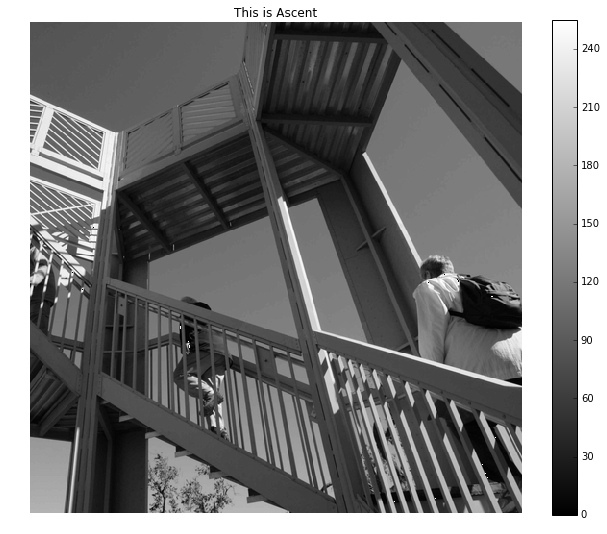

In [13]:
figsize(11,11)
imshow(xsharp, interpolation='nearest', cmap=cm.gray, vmin=0, vmax=255)
plt.axis("off")
# Without specifying vmin and vmax, imshow auto-adjusts its range so that black and white are
# the min and max of the data, respectively, like Matlab's imagesc.
colorbar()       # displays the color bar close to the image
#axis('off')     # uncomment to remove the axes
subplots_adjust(top=0.75)
title('This is Ascent')

In [15]:
mask = rand(xsharp.shape[0],xsharp.shape[1])>0.80

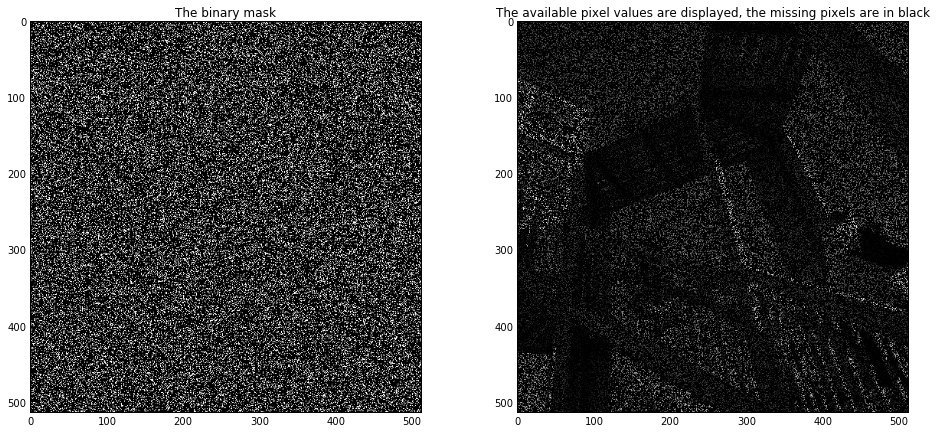

In [16]:
fig, (subfig1,subfig2) = subplots(1,2,figsize=(16,7)) # one figure with two horizontal subfigures
subfig1.imshow(mask, cmap=cm.gray)
subfig2.imshow(mask*xsharp, cmap=cm.gray)
subfig1.set_title('The binary mask')
subfig2.set_title('The available pixel values are displayed, the missing pixels are in black')

In [17]:
y = mask*xsharp

In [18]:
D = lambda x : c_['2,3',r_[diff(x,1,0), zeros([1,x.shape[1]])],c_[diff(x,1,1), zeros([x.shape[0],1])]]

In [19]:
Dadj = lambda v : r_['0,2',-v[0,:,0],-diff(v[:-1,:,0],1,0),v[-2,:,0]] + c_['1,2',-v[:,0,1],-diff(v[:,:-1,1],1,1),v[:,-2,1]]

In [20]:
def prox_g_conj (u, Lambda) :
    return u/tile(maximum(sqrt(sum(u**2,2,keepdims=True))/Lambda,1),(1,1,2)) # soft-thresholding

In [21]:
A = mask

In [22]:
def prox_f (x, y) :
    x[mask]=y[mask]
    return x

In [14]:
tau = 1
rho = 1
sigma = 1/tau
nbiter = 1500

(N1,N2) = shape(xsharp)
x = zeros([N1,N2])
u = zeros([N1,N2, 2])
En_array = zeros(nbiter)
for iter in range(nbiter):  # iter goes from 0 to nbiter-1
    xtilde = prox_f(x - tau*Dadj(u),y)
    utilde = prox_g_conj(u + sigma*D(2*xtilde-x), sigma)
    x = x + rho*(xtilde - x)
    u = u + rho*(utilde - u)
    En_array[iter] = sum(sqrt(sum(D(x)**2,2)))
    
x_restored = x

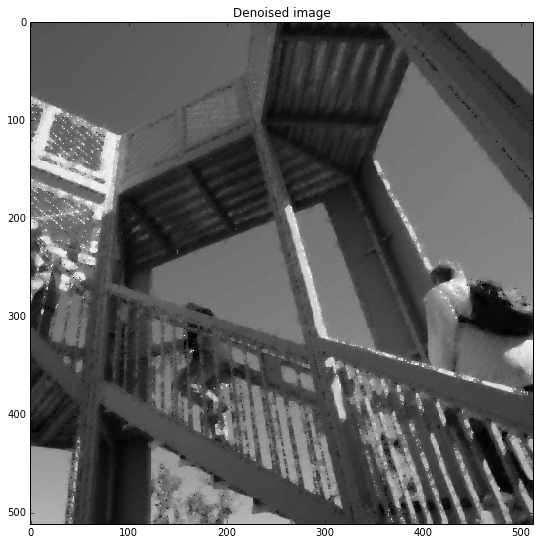

In [15]:
figsize(9,9)
imshow(x_restored, interpolation='nearest', cmap=cm.gray, vmin=0, vmax=255)
title('Denoised image')
plt.axis("off")

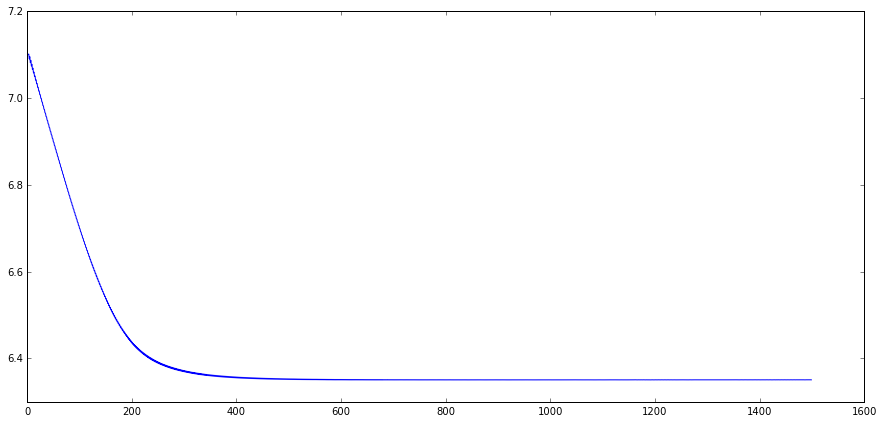

In [16]:
figsize(15,7)
plot(log10(En_array))

In [2]:
#math and linear algebra stuff
import numpy as np
from skimage import measure
from scipy import misc
import scipy.signal as scis
import matplotlib.pyplot as plt

Image Deblurring using original Chambolle Pock algorithm
---------------------------------------------
\begin{equation}
    \text{Let } \qquad \underset{x}{min} \quad f(x) + g(Lx)
\end{equation}

be a generic optimization problem, where $f$ and $g$ are convex functions, whose proximity operators can be computed, and $L$ is a linear operator. The dual problem is

\begin{equation}
    \underset{u}{max} \quad -f^*(-L^*u) - g^*(u)
\end{equation}

or equivalently

\begin{equation}
    \underset{u}{min} \quad f^*(-L^*u) + g^*(u)
\end{equation}
  
This formulation is often called an analysis formulation, Antonin Chambolle and Pock gave us an algorithm to solve that problem, which do not depend on the invertibility of the operator L (like ADMM does). This algorithm reads:
  
The (relaxed) Chambolle-Pock algorithm takes initial estimates $x^{(0)}$ and $u^{(0)}$ of the primal and dual solutions, a parameter $\tau>0$, a second parameter $\sigma>0$ such that $\sigma \tau \|L\|^2 < 1$, and a relaxation parameter $0<\rho<2$, and iterates, for $k=1,2,\ldots$:
  
\begin{align*}
    u^{k} &= \mathrm{prox}_{\sigma g^*}( u^{k-1} + \sigma L(\tilde{x}^{k-1}) \\
    x^{k} &= \mathrm{prox}_{\tau f}(  x^{k-1}-\tau L^* u^{k} ) \\
    \tilde{x}^{k} &= x^{k} + \rho (x^{k}-x^{k-1})\\
\end{align*}
  
Where, $x^{(k)}$ converges to a primal solution $x^\star$ and $u^{(k)}$ converges to a dual solution $u^\star$.

We recall that being able to compute the proximity operator of $f^*$ is equivalent to being able to compute the proximity operator of $f$, thanks to the Moreau identity:
  
\begin{equation}
    x = \mathrm{prox}_{\gamma f^*}(x) + \gamma \mathrm{prox}_{\frac{f}{\gamma}}(\frac{x}{\gamma})
\end{equation}

(-0.5, 511.5, 511.5, -0.5)

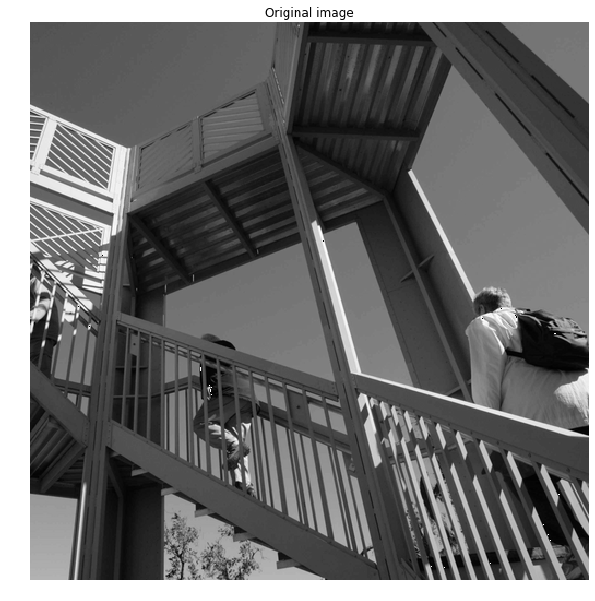

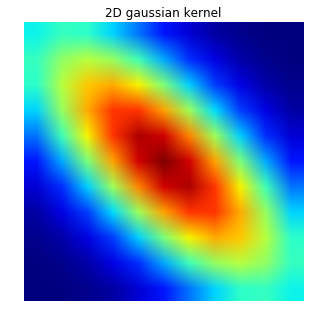

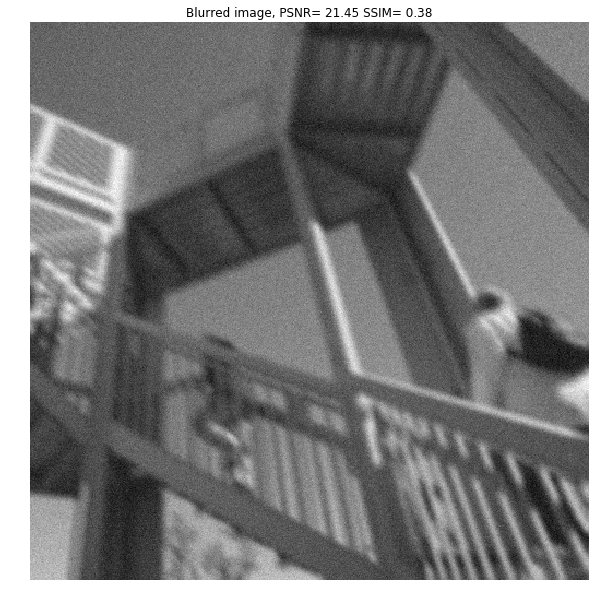

In [23]:
"""
  import dataset, and convert to fp64
"""
xbar = misc.ascent().astype(np.float64)
dyn = xbar.ptp()
#Plot
plt.figure(0,figsize=(10,10))
plt.title("Original image")
plt.imshow(xbar,interpolation="nearest", cmap=plt.cm.gray)
plt.axis("off")

"""
  Define a 2D, non axis aligned gaussian kernel, and its time reversed version
"""
#define mesh
sizeK = 11 # must be odd
X,Y=np.meshgrid(np.linspace(-1,1,sizeK),np.linspace(-1,1,sizeK))
xvec = np.array([np.reshape(X,X.size),np.reshape(Y,Y.size)])
#define a 2D rotation matrix:
def GetRotMat( theta ):
  return np.array([[np.cos(theta),-np.sin(theta)],
    [np.sin(theta),np.cos(theta)]])
Mrot = GetRotMat( 3.*np.pi/4. )
#define anisotropic and rotated gaussian
Sigma = np.dot(Mrot,np.dot(np.diag([0.15,1]),Mrot.T))
mu = np.array([[0],[0]])
coef = 1/np.sqrt(np.power(2*np.pi,2)*np.linalg.det(Sigma))
#2-dimensional gaussian pdf
test=np.dot(np.linalg.inv(Sigma),xvec-mu)
K=coef * np.exp(-0.5* np.sum(test*(xvec-mu),0))
K=np.reshape(K,X.shape)/K.sum()
#Normalize
K/=K.sum()
KT=K[::-1,::-1]
#Plot
plt.figure(1,figsize=(5,5))
plt.title("2D gaussian kernel")
plt.imshow(K)
plt.axis("off")

"""
  Perform convolution with gaussian kernel + add noise
"""
blurred=scis.convolve2d(xbar, K, mode='same', boundary='symm', fillvalue=0)
stddev = 10
blurred += np.random.normal(0,stddev,blurred.shape)
psnrBlurred = measure.compare_psnr(xbar, blurred, dynamic_range=dyn)
ssimBlurred = measure.compare_ssim(xbar, blurred, win_size=5, dynamic_range=dyn)
#Plot
plt.figure(2,figsize=(10,10))
plt.title("Blurred image, PSNR= "+("%.2f" % psnrBlurred)+
  " SSIM= "+("%.2f" % ssimBlurred))
plt.imshow(blurred, interpolation="nearest", cmap=plt.cm.gray)
plt.axis("off")

## Application to TV minimization
  
Lets cast the following minimization problem, based on the total variation regularization:
  
\begin{equation}
    \underset{w \in C \subseteq \mathbb{R}^{n\times n}}{min} \quad \|Aw-y\|_2^2+\lambda\|w\|_{TV}
\end{equation}

The trick is to consider that this problems maps to Chambolle Pock generic problem if we forget about the $f$ function, which will be identically zero everywhere, and put both the data fitting term, and the total variation inside $g$.
  
In this case the linear operator $L$ is actually the concatenation of the spatial gradient operator $\nabla$ and the A matrix:
  
\begin{equation}
    L = \begin{pmatrix} A \\ \nabla \end{pmatrix}
\end{equation}
  
We can notice that we will model the dual variable $u$ as the couple $p,q$, with $p$ having the dimensionality of the output vector space of $A$, and $q$ having the dimensionality of $2\times$ the input image size for $\nabla$ a 2D spatial gradient operator.
  
The $f$ function is a trivial constant function equal to zero, its proximity operator is the identity. Its convex conjugate reads $f^*(u)= \underset{z}{max} \quad \langle u, z \rangle_{\mathbb{R}^n}$ which reduces to the constraint $u=0$ that translate into the indicator function of 0 : $\delta_0(u)$\\
The $g$ function can be seen as a sum of two convex functions:
  
\begin{align}
    g(x_1,x_2) &= g_1(x_1) + g_2(x_2) \\
\end{align}
  
Where $g_1(x_1)=\|x_1 -y\|_2^2 $ and $g_2(x_2)=\lambda \|(|x_2|)\|_1$, with $x_1=Aw$ and $x_2=\nabla w$, we define $(|\cdot|)$ the 2-wise magnitude operator for $x_2=\nabla w$ a vector where $x$ and $y$ spatial gradients have been concatenated.

Deriving the convex conjugation of those functions give us, first:

### Convex conjugate of $g_1$

\begin{align}
  g_1^*(p)= \underset{z}{max} \quad \langle p, z \rangle_{\mathbb{R}^n} - \|z -y\|_2^2
\end{align}

Where $c(z) = \langle p, z \rangle_{\mathbb{R}^n} - \|z -y\|_2^2$ is a nice concave function that is differentiable, let's see where its derivative vanishes:
  
\begin{align}
    \frac{\partial c}{\partial z} &= 0\\
    \frac{\partial \langle p, z \rangle }{\partial z} - \left(
    \frac{\partial \langle z, z \rangle }{\partial z} +
    \frac{\partial \langle y, y \rangle }{\partial z} - 2
    \frac{\partial \langle z, y \rangle }{\partial z} \right) &= 0\\
    p - 2z + 2y &= 0\\
    z = \frac{1}{2} p + y
\end{align}
  
Now that we have found the optimum, we can express the convex conjugate $g_1^*(p)$:
  
\begin{align}
    g_1^*(p) &= c(\frac{1}{2} p + y)\\
    &= \langle p, \frac{1}{2} p + y \rangle - \| \frac{1}{2} p + y - y \|_2^2\\
    &= \frac{1}{2} \|p\|_2^2 + \langle p, y \rangle - \frac{1}{4} \|p\|^2 \\
    &= \frac{1}{4} \|p\|^2 + \langle p, y \rangle_{\mathbb{R}^n}
\end{align}

We can notice that it would have been more convenient to put a $\frac{1}{2}$ factor before the quadratic term.
Let's compute its proximity operator:
  
\begin{align}
    prox_{\gamma g_1^*}(z) = \underset{x}{argmin} \quad \frac{1}{2} \|x-z\|_2^2 + \gamma \left( \frac{1}{4} \|x\|^2 +
    \langle x, y \rangle_{\mathbb{R}^n} \right)
\end{align}
  
Where $d(x) = \frac{1}{2} \|x-z\|_2^2 + \gamma \frac{1}{4} \|x\|^2 + \gamma \langle x, y \rangle_{\mathbb{R}^n}$ is a nice convex function that is differentiable, let's see where its derivative vanishes:

\begin{align}
    \frac{\partial d}{\partial x} &= 0\\
    \frac{1}{2} \left(
    \frac{\partial \langle x, x \rangle }{\partial x} +
    \frac{\partial \langle z, z \rangle }{\partial x} - 2
    \frac{\partial \langle x, z \rangle }{\partial x} \right) +
    \gamma \frac{1}{4}\frac{\partial \langle x, x \rangle }{\partial x} +
    \gamma \frac{\partial \langle x, y \rangle }{\partial x} &= 0\\
    x-z+\frac{\gamma}{2}x+\gamma y &=0\\
    \left( \frac{\gamma}{2} + 1 \right) x - z + \gamma y &= 0\\
    x &= \frac{z-\gamma y}{\frac{\gamma}{2} + 1}
\end{align}
  
Now, we have the following proximity operator:

\begin{align}
    prox_{\gamma g_1^*}(p) = \frac{z-\gamma y}{\frac{\gamma}{2} + 1}
\end{align}
  
Let's now take a look at the convex conjugate of $g_2$:

### Convex conjugate of $g_2$
  
\begin{equation}
    g_2^*(q)= \underset{z}{max} \quad \langle q, z \rangle_Z - \lambda \|(|z|)\|_1
\end{equation}
  
Where $z$ is taken from $Z$, the set of 2-sized spatial gradient vector fields for a 2D image. It can be seen that, the first term reads:
  
\begin{equation}
    \sum_i (\nabla_x q)_i (\nabla_x z)_i + (\nabla_y q)_i (\nabla_y z)_i \leq \sum_i |\nabla q|_i |\nabla z|_i
\end{equation}
  
and the second term is equal to $\lambda \sum_i |\nabla z|_i$.\\

Often in convex conjugation, the first term will make the function explode to $\infty$ depending on a simple condition over the support of $q$. Here, it can be easily seen that all vector elements of the vector field $\nabla q$ must have their magnitude inferior to $\lambda$, otherwise, we can choose a $z$ such that the function is infinitely valued.
  
This elementwise condition reduces to a box condition that can be written as:
  
\begin{equation}
    g_2^*(q)= \delta_{Box(\lambda)} (|q|)
\end{equation}
  
Which defines a convex set, whose proximity operator simply amount to the projection onto this set. In practice the proximity operator is equivalent to a pixel-wise thresholding of any 2-valued gradient vector whose magnitude would be superior to $\lambda$.

### Wrapping up
  
We are now able to give the dual problem of the original TV minimization problem:
  
\begin{align}
    \underset{u}{max} \quad & -f^*(-L^*u) - g^*(u)\\
    \underset{p,q}{max} \quad & -\delta_{0}(-A^* p -\nabla^* q) -
      \frac{1}{4} \|p\|^2 - \langle p, y \rangle_{\mathbb{R}^n} - \delta_{Box(\lambda)} (|q|)
\end{align}
  
A really interesting property for the meticulous data scientist, is that it can actually measure the primal-dual gap for the current set of primal-dual solution:
  
\begin{equation}
    PD(w,p,q) = \|Aw-y\|_2^2 + \lambda \|(|\nabla w|)\|_1 + \frac{1}{4} \|p\|^2 + \langle p, y \rangle_{\mathbb{R}^n}
\end{equation}
  
 A primal-dual gap numerically close to zero can be considered as an optimality certificate.

/home/gnthibault/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:75: RuntimeWarning: invalid value encountered in log10


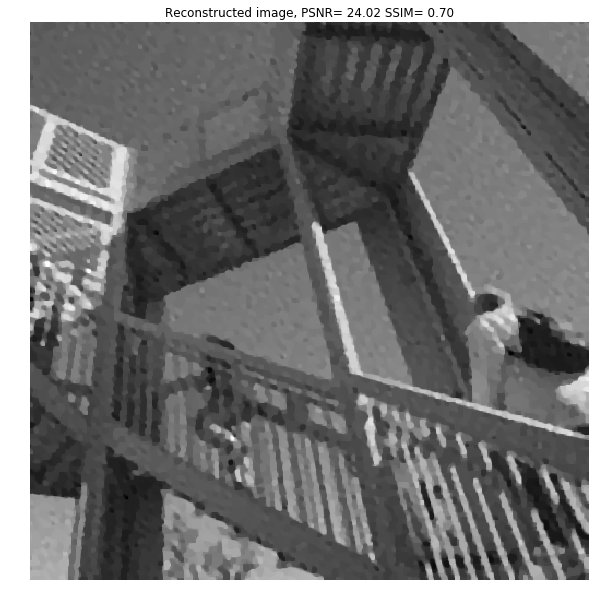

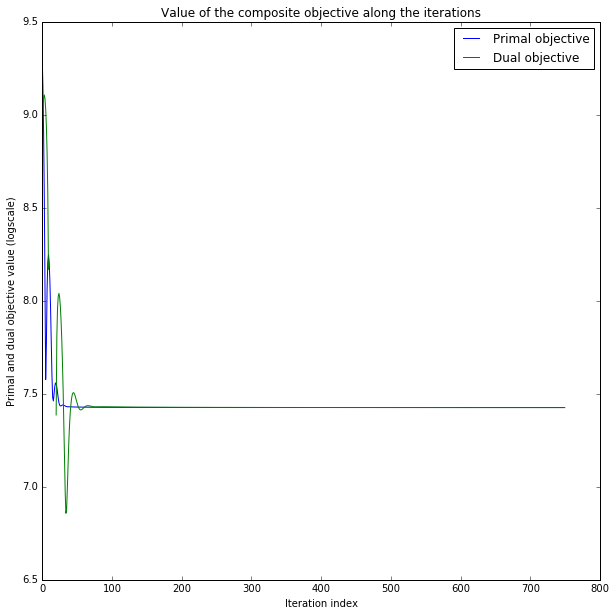

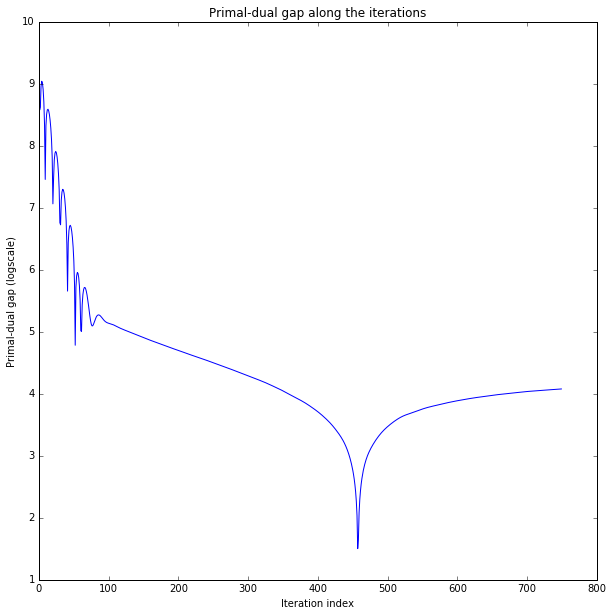

In [24]:
#A can be an arbitrary linear operator
A = lambda x : scis.convolve2d(x, K, mode='same', boundary='symm', fillvalue=0)
AT = lambda x : scis.convolve2d(x, KT, mode='same', boundary='symm', fillvalue=0)

def GetLNormThroughPowerMethod(init):
  """
    Perform a few iteration of the power method in order to obtain
    the maximum eigenvalue of the L^*L operator
  """
  x=init.copy()
  for i in range(10):
    x = AT(A(x))+Dadj(D(x))
    s = np.linalg.norm(x)
    x /= s
  return np.sqrt(s)

def prox_f(inf) :
  """

  """
  return inf

def prox_g_conj_1 (p, y, sigma) :
  """

  """
  return (p-sigma*y)/(0.5*sigma+1.)

def prox_g_conj_2 (u, Lambda) :
  """
    Proximity operator for the G_2* function
  """
  ret = u.copy()
  n = np.maximum(np.sqrt(np.sum(u**2, 2))/Lambda, 1.0)
  ret[:,:,0]/=n
  ret[:,:,1]/=n
  return ret

Lnorm = GetLNormThroughPowerMethod(AT(blurred))*1.1 #take 10% margin
tau = 1./Lnorm
sigma = 1./Lnorm
rho = 1. #rho > 1 allows to speed up through momentum effect
nbIter = 750
lambdaTV = 1.

xk = np.zeros_like(blurred)  #primal var at current iteration
x_tilde = np.zeros_like(xk)  #primal var estimator
p = np.zeros_like(blurred) #dual var 1
q = np.zeros([xbar.shape[0],xbar.shape[1],2]) #dual var 2
primObj = np.zeros(nbIter)
dualObj = np.zeros_like(primObj)
for iter in range(nbIter):  # iter goes from 0 to nbIter-1
  p = prox_g_conj_1( p + sigma * A(x_tilde), blurred, sigma )
  q = prox_g_conj_2( q + sigma * D(x_tilde),lambdaTV )
  dualObj[iter] = -0.25*np.linalg.norm(p)**2 - np.dot(p.flatten(),blurred.flatten())
  xk1 = xk
  xk = prox_f( xk - tau * Dadj(q) - tau * AT(p) )
  x_tilde = xk + rho*( xk - xk1 )
  primObj[iter] = lambdaTV * np.sum(np.sqrt(np.sum(D(xk)**2,2))) + \
    np.linalg.norm(A(xk)-blurred)**2

#Evaluate quality
psnrXk = measure.compare_psnr(xbar, xk, dynamic_range=dyn)
ssimXk = measure.compare_ssim(xbar, xk, win_size=5, dynamic_range=dyn)

#Plot
plt.figure(3,figsize=(10,10))
plt.title("Reconstructed image, PSNR= "+("%.2f" % psnrXk)+
  " SSIM= "+("%.2f" % ssimXk))
plt.imshow(xk, interpolation="nearest", cmap=plt.cm.gray)
plt.axis("off")
plt.figure(4,figsize=(10,10))
plt.xlabel("Iteration index")
plt.ylabel("Primal and dual objective value (logscale)")
plt.plot(range(nbIter),np.log10(primObj),label="Primal objective")
plt.plot(range(nbIter),np.log10(dualObj),label="Dual objective")
plt.title("Value of the composite objective along the iterations")
plt.legend()
plt.show()
plt.figure(5,figsize=(10,10))
plt.xlabel("Iteration index")
plt.ylabel("Primal-dual gap (logscale)")
plt.plot(range(nbIter),np.log10(np.abs(primObj-dualObj)))
plt.title("Primal-dual gap along the iterations")